In [9]:
!pip install Pillow
!pip install scikit-image
!pip install numpy
!pip install torch
!pip install transformers
!pip install matplotlib
!pip install diffusers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.1
    Uninstalling huggingface-hub-0.20.1:
      Successfully uninstalled huggingface-hub-0.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.24.0 requires huggingface-hub>=0.19.4, but you have huggingface-hub 0.17.3 which is incompatible.
daami2i 0.0.1 requires diffusers==0.9.0, but you have diffusers 0.24.0 which is incompatible.
daam 0.1.0 requires accelerate==0.18.0, but you have accelerate 0.25.0 which is incompatible.
daam 0.1.0 requires diffusers==0.16.1, but you have diffusers 0.24.0 which is incompatible.
daam 0.1.0 requires transformers==4.27.4, but you have transformers 4.34.0 which is incompatible.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Using cached huggingface_hub-0.20.1-py3-none-any.whl (330 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.20.1 which is incompatible.
daami2i 0.0.1 requires diffusers==0.9.0, but you have diffusers 0.24.0 which is incompatible.
daam 0.1.0 requires accelerate==0.18.0, but you have accelerate 0.25.0 which is incompatible.
daam 0.1.0 requires diffusers==0.16.1, but you have diffusers 0.24.0 which is incompatible.
daam 0.1.0 requires transformers==4.27.4, but you have transformers 4.34.0 which is incompatibl

Hi Pooya! This notebook really works as a general object-to-object swapper between images, but let's keep it at t-shirts for now

In [1]:
prompts = ["t-shirt"]

To do this I am exclusively using stable diffusion (specifically taking advantage of CLIP's multi-modality) to do this. First, let's use cross-attention to segment both t-shirts out of the image.

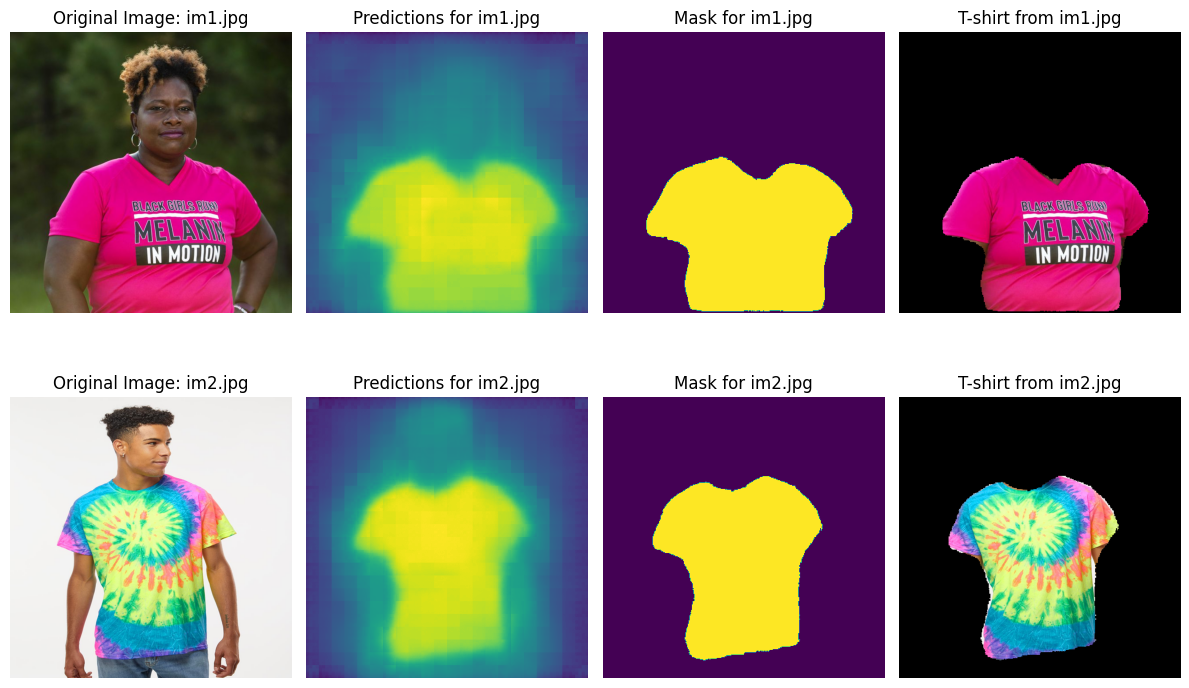

In [6]:
from PIL import Image
from skimage.transform import resize
import numpy as np
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import matplotlib.pyplot as plt

# Initialize variables
height = 512
width = 512
img_files = ["im1.jpg", "im2.jpg"]

# Initialize CLIPSeg processor and model
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Function to process each image
def process_image(img_path):
    # Load and resize image
    image = Image.open(img_path).resize((width, height), Image.LANCZOS)

    # Prepare inputs
    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract predictions
    preds = outputs.logits.unsqueeze(1)

    # Generate mask and resize
    mask = preds.transpose(2, 1) > 0
    mask = np.array(mask.cpu().numpy())
    mask_resized = resize(mask, (width, height))

    # Apply mask to image
    input_image = np.array(image)
    tshirt = input_image * mask_resized

    return image, preds, mask, tshirt

# Prepare the subplot grid
num_images = len(img_files)
plt.figure(figsize=(12, num_images * 4))

people = []
masks = []

# Process each image and plot in the grid
for i, img_path in enumerate(img_files):
    original, preds, mask, tshirt = process_image(img_path)
    
    # Original Image
    plt.subplot(num_images, 4, i * 4 + 1)
    plt.imshow(original)
    plt.title(f"Original Image: {img_path}")
    plt.axis('off')
    
    # Predictions
    plt.subplot(num_images, 4, i * 4 + 2)
    plt.imshow(preds.transpose(2, 1))
    plt.title(f"Predictions for {img_path}")
    plt.axis('off')
    
    # Mask
    plt.subplot(num_images, 4, i * 4 + 3)
    plt.imshow(mask)
    plt.title(f"Mask for {img_path}")
    plt.axis('off')
    
    # T-shirt
    plt.subplot(num_images, 4, i * 4 + 4)
    plt.imshow(tshirt)
    plt.title(f"T-shirt from {img_path}")
    plt.axis('off')

    masks.append(mask)
    people.append(original)



# Adjust layout and display the plot
plt.tight_layout()
plt.show()


(Sorry about the aspect ratio, the image can be stretched back in post anyways)
The idea with my approach is to get a text embedding for one of the t-shirts like so:

In [3]:
from diffusers.pipelines.blip_diffusion import Blip2QFormerModel
from diffusers.pipelines.blip_diffusion.blip_image_processing import BlipImageProcessor
from diffusers.pipelines.blip_diffusion.modeling_ctx_clip import ContextCLIPTextModel
from transformers import CLIPTokenizer
from diffusers.utils import load_image


def encode_prompt(query_embeds, prompt):
    device = "cuda"
    max_len = text_encoder.text_model.config.max_position_embeddings
    max_len -= qformer.config.num_query_tokens

    tokenized_prompt = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    ).to(device)

    batch_size = query_embeds.shape[0]
    ctx_begin_pos = [2] * batch_size

    text_embeddings = text_encoder(
        input_ids=tokenized_prompt.input_ids,
        ctx_embeddings=query_embeds,
        ctx_begin_pos=ctx_begin_pos,
    )[0]

    return text_embeddings
    
qformer = Blip2QFormerModel.from_pretrained("Salesforce/blipdiffusion", subfolder="qformer",torch_dtype=torch.float16).to("cuda")
processor = BlipImageProcessor.from_pretrained("Salesforce/blipdiffusion", subfolder="image_processor")
text_encoder = ContextCLIPTextModel.from_pretrained("Salesforce/blipdiffusion", subfolder="text_encoder").to("cuda")
tokenizer = CLIPTokenizer.from_pretrained("Salesforce/blipdiffusion", subfolder="tokenizer")

cond_image = load_image(Image.open(img_files[0]).convert("RGB"))
im = torch.tensor(processor.preprocess(cond_image)['pixel_values'][0]).permute(0, 1, 2).unsqueeze(0).float().cuda()
q = qformer(image_input=im, text_input=[''], return_dict=False)

embeds = encode_prompt(q, "t-shirt")

And then simply use that as a prompt with the inpainting pipeline

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

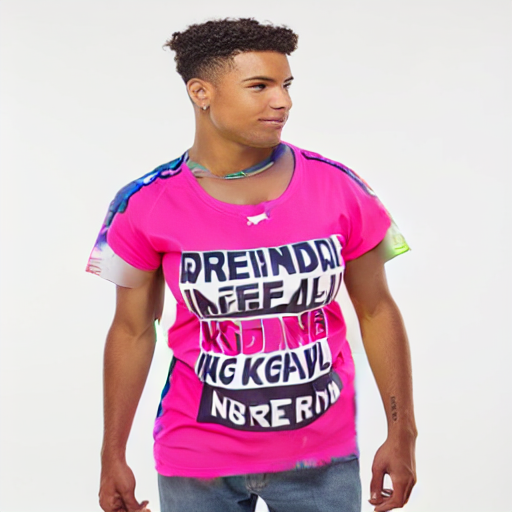

In [7]:
import diffusers
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageDraw, ImageFilter
from transformers import CLIPTextModel, CLIPTokenizer
import torch
from tqdm.auto import tqdm
from PIL import Image
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

SIZE = 1024
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
model_id = "runwayml/stable-diffusion-inpainting"
model_dir  = "Salesforce/blipdiffusion"
torch_device = "cuda"
# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker = None)
pipe.vae = AutoencoderKL.from_pretrained(model_dir, subfolder="vae").to(torch_device)
pipe.tokenizer = CLIPTokenizer.from_pretrained(model_dir, subfolder="tokenizer")
pipe.text_encoder = CLIPTextModel.from_pretrained(model_dir, subfolder="text_encoder").to(torch_device)
pipe.unet = UNet2DConditionModel.from_pretrained(model_dir, subfolder="unet").to(torch_device) 
pipe.scheduler = PNDMScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = pipe.to("cuda")
pipe.enable_attention_slicing()
#pipe.enable_vae_slicing()
pipe.enable_xformers_memory_efficient_attention()
#pipe.enable_sequential_cpu_offload()
#pipe.enable_model_cpu_offload()
#open render.png as rgb
image = Image.open(img_files[1]).convert("RGB")
#upscale to 512x512
image = image.resize((width, height), Image.BICUBIC)
#revert mask
mask = masks[1]
#feather the mask
mask = mask.astype(np.uint8)*255
mask = Image.fromarray(mask[:,:,0])
#smoth the mask
mask = mask.filter(ImageFilter.GaussianBlur(radius=10))

image = pipe(prompt_embeds=embeds, image = image, mask_image = mask, num_inference_steps=30, guidance_scale=7).images[0]
image

Et voila'. Text got lost in translation but that's probably beacuse im using an early version of SD (text embeddings are 1024 dimensional in SD>2, and i couldnt find the corresponding qformer.) 
Please feel free to try this with whatever images you like, it should work regardless. There's a lot of stuff i do here that i didnt explain, so if you have any questions for tomorrow please do ask